#  Desafio Kaggle - Sentiment Analysis

O presente desafio foi retirado do site https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

Os dados foram baixados através do site, na aba "Data". Os dados constituem dois conjuntos de críticas do filme "The Rotten Tomatoes": um para treinamento e outro para teste de benchmarking (não possui os sentimentos rotulados). Para mais detalhes, ver o site citado acima.

Já a construção da rede foi baseada em uma aula que tive da Udacity, do "PyThorch Scholarship Challenge", no qual aprendi sobre redes neurais profundas (CNNs, LSTMs, etc.) Não há um link específico para o código desenvolvido por eles, mas vou deixar o notebook, que utilizei como base, junto dos arquivos. 

### Sobre os dados

O dataset é composto de arquivos separados por "tab", contendo frases do dataset do Rotten Tomatoes.

O arquivo 'train.tsv' contém as frases e suas correspondentes labels de sentimento. Ele também possui uma coluna chamada "SenteceId" que indica a qual frase aquela sentença pertence. E cada linha do documento possui uma "PhraseId".

O objetivo é treinar um algoritmo capaz de classificar esses reviews (contidos no conjunto de treinamento) em labels de 0 a 4, sendo:

0 - negativo

1 - um pouco negativo

2 - neutro

3 - um pouco positivo

4 - positivo

In [1]:
# Abrindo os arquivos:
import pandas as pd

train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

In [2]:
# Arquivo 'train.tsv'

train.head(100)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [3]:
train.shape

(156060, 4)

In [4]:
train['SentenceId'][156059]

8544

In [5]:
# Ultima SentenceId = 8544

sentence_id = [i for i in range(8545)]
print(sentence_id[-1])

print(len(train))

8544
156060


In [6]:
# Arquivo 'test.tsv'

test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [7]:
test.shape

(66292, 3)

## Implementação de uma RNN utilizando PyTorch

Escolhi utilizar a biblioteca do PyTorch, baseada na biblioteca torch, para a implementação de uma rede neural. Esta biblioteca é utilizada para aplicações de deep learning e NLP.
>O PyTorch é um software open source gratuito e foi inicialmente desenvolvido pela equipe de pesquisa de AI do Facebook.

### Arquitetura da Rede

Vou, então, implementar uma rede neural recorrente que classifica os sentimentos desses reviews. Na imagem abaixo podemos ter uma melhor ideia de como ela é composta (**Obs.**: No lugar das camadas Sigmoid, vamos utilizar uma camada totalmente conectada com ativação softmax):

<img src="network_diagram.png" width=40%>

**Primeiro, vamos passar as palavras por uma camada de "mergulho" (embedding layer, em inglês)**
>Precisamos dessa camada inicial pois temos milhares de palavras e precisamos ser mais eficientes nas representações de nossos dados de input. No nosso caso, esta camada é utilizada para fins de redução da dimensionalidade. Utilizando essa camada de mergulho, e deixando o algoritmo aprender sozinho uma nova representação, já é possível obter uma boa acurácia.

**Após passarmos o input na camada de mergulho, os novos embeddings são passados pelas células LSTMs**
>A LSTM é responsável por adicionar conexões recorrentes eficientes para o tratamento de textos, nos dando informações sobre a sequência de texto, ao invés de informações das palavras de forma isolada.

**Por fim, a LSTM gera um output que é passado por uma última camada totalmente conectada**
>A última camada vai ser composta por uma camada totalmente conectada (de 5 neurons), pois temos 5 tipos de inputs diferentes. Por fim, a função de ativação escolhida vai ser a função softmax, que é uma boa escolha para tratar a classificação multiclasse.

(Considerando a imagem anterior, não é necessário se preocupar com as saídas da função de ativação, exceto para a **última**; podendo ignorar as restantes. Mais a frente, vamos calcular a loss function comparando o output do último passo com os labels de treinamento.)

----
## Pré-processamento dos dados

O primeiro passo antes de construir a rede neural é transformar os dados na melhor forma para inserir na rede. Como vamos usar camadas de embedding, vai ser necessário codificar cada palavra como um inteiro. Além disso, também é necessário "limpar" os ruídos.

Os passos de processamento serão divididos em:
>* Vamos reduzir o noise dos dados, obtendo uma nova tabela de treinamento com menos frases (Vamos inicialmente considerar apenas as frases inteiras);
* Vamos excluir os períodos e pontuações diversas (se houverem);
* Por fim, vamos combinar todas as palavras em uma grande string para codificar as palavras em vetores unitários.

In [8]:
# Vamos então reabrir os arquivos e entender como eles se organizam:

g = open('train.tsv','r')
train = list(map(lambda x: x[:-1], g.readlines()))
g.close()

g = open('test.tsv','r')
test = list(map(lambda x: x[:-1], g.readlines()))
g.close()

In [9]:
train[:10]

['PhraseId\tSentenceId\tPhrase\tSentiment',
 '1\t1\tA series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .\t1',
 '2\t1\tA series of escapades demonstrating the adage that what is good for the goose\t2',
 '3\t1\tA series\t2',
 '4\t1\tA\t2',
 '5\t1\tseries\t2',
 '6\t1\tof escapades demonstrating the adage that what is good for the goose\t2',
 '7\t1\tof\t2',
 '8\t1\tescapades demonstrating the adage that what is good for the goose\t2',
 '9\t1\tescapades\t2']

In [10]:
test[:10]

['PhraseId\tSentenceId\tPhrase',
 '156061\t8545\tAn intermittently pleasing but mostly routine effort .',
 '156062\t8545\tAn intermittently pleasing but mostly routine effort',
 '156063\t8545\tAn',
 '156064\t8545\tintermittently pleasing but mostly routine effort',
 '156065\t8545\tintermittently pleasing but mostly routine',
 '156066\t8545\tintermittently pleasing but',
 '156067\t8545\tintermittently pleasing',
 '156068\t8545\tintermittently',
 '156069\t8545\tpleasing']

In [11]:
# Vamos por partes... Primeiramente vejamos uma forma de separar cada frase do treinamento

linha_1 = train[1]
lista_teste = linha_1.split('\t')
print("SentenceId: " + lista_teste[1] +"\nFrase: " + lista_teste[2] + "\nSentimento: " + lista_teste[3])

SentenceId: 1
Frase: A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
Sentimento: 1


In [12]:
# Fazendo isso para todos os dados (primeiro para treinamento):

train_lines = []
for i in range(len(train)):
    train_lines.append(train[i])

train_set_lines = []
for i in range(len(train_lines)):
    dados_linha = train_lines[i]
    dados_linha = dados_linha.split('\t')
    train_set_lines.append(dados_linha)

print(train_set_lines[:5])

[['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], ['1', '1', 'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .', '1'], ['2', '1', 'A series of escapades demonstrating the adage that what is good for the goose', '2'], ['3', '1', 'A series', '2'], ['4', '1', 'A', '2']]


In [13]:
# E agora para os dados de teste:

test_lines = []
for i in range(len(test)):
    test_lines.append(test[i])

test_set_lines = []
for i in range(len(test_lines)):
    dados_linha = test_lines[i]
    dados_linha = dados_linha.split('\t')
    test_set_lines.append(dados_linha)

print(test_set_lines[:5])

[['PhraseId', 'SentenceId', 'Phrase'], ['156061', '8545', 'An intermittently pleasing but mostly routine effort .'], ['156062', '8545', 'An intermittently pleasing but mostly routine effort'], ['156063', '8545', 'An'], ['156064', '8545', 'intermittently pleasing but mostly routine effort']]


In [14]:
# Arrumando o tipo do dado "Sentiment". Vamos transformar as strings
# em inteiros:

for i in range(1, len(train_set_lines)):
    train_set_lines[i][3] = int(train_set_lines[i][3])
    
print(train_set_lines[50])

['50', '1', 'none of which amounts to much of a story', 1]


In [15]:
# Arrumando as frases. Vamos substituir todas as maiusculas por
# minusculas e tirar quaisquer pontuaçoes desnecessárias dos dados
# (tanto de treinamento quanto de teste):

import re # Esta é a biblioteca ReGex, usada para auxiliar a localização
          # de padrões

for i in range(len(train_set_lines)):
    train_set_lines[i][2] = train_set_lines[i][2].lower()
    string = train_set_lines[i][2]
    train_set_lines[i][2] = re.sub('[^a-z0-9\s]', '', string)
    
for i in range(len(test_set_lines)):
    test_set_lines[i][2] = test_set_lines[i][2].lower()
    string = test_set_lines[i][2]
    test_set_lines[i][2] = re.sub('[^a-z0-9\s]', '', string)

In [16]:
print("Sentimento: "+str(train_set_lines[50][3])+"\nFrase para treino: "+train_set_lines[50][2])
print()
print("Frase para teste: "+test_set_lines[1][2])

Sentimento: 1
Frase para treino: none of which amounts to much of a story

Frase para teste: an intermittently pleasing but mostly routine effort 


In [17]:
# Vamos agora criar uma lista de palavras (um vocabulário
# para uso futuro):

all_text = []
for i in range(1,len(train_set_lines)):
    all_text.append(train_set_lines[i][2])

for i in range(1,len(test_set_lines)):
    all_text.append(test_set_lines[i][2])

all_text = ' '.join(all_text)
print(all_text[:1000])

# Para quem manja de comprehensions, podemos escrever o mesmo
# código acima como:
# all_text_comprehension = ' '.join([train_set_lines[i][2] for i in range(1,len(train_set_lines))])
# print(all_text_comprehension[:1000])

a series of escapades demonstrating the adage that what is good for the goose is also good for the gander  some of which occasionally amuses but none of which amounts to much of a story  a series of escapades demonstrating the adage that what is good for the goose a series a series of escapades demonstrating the adage that what is good for the goose of escapades demonstrating the adage that what is good for the goose escapades demonstrating the adage that what is good for the goose demonstrating the adage demonstrating the adage the adage that what is good for the goose that what is good for the goose what is good for the goose is good for the goose good for the goose for the goose goose is also good for the gander  some of which occasionally amuses but none of which amounts to much of a story  is also good for the gander  some of which occasionally amuses but none of which amounts to much of a story is also also good for the gander  some of which occasionally amuses but none of which 

In [18]:
words = all_text.split()
print(words[:30])

['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts']


### Codificando as palavras

Para utilizarmos a camada de mergulho ("embedding layer"), precisamos passar números inteiros na rede. Uma forma de fazer isso é criando um dicionário que mapeia palavras para números, tornando possível a conversão de cada uma das palavras dos reviews em números.

Mais tarde, vamos acrescentar zeros (o chamado "padding") nos vetores de input.

In [19]:
# Vamos então contar as palavras (para futuras análises - opcional)
from collections import Counter

counts = Counter(words)
print(counts)

Counter({'the': 71162, 'a': 50065, 'of': 44659, 'and': 44234, 'to': 31499, 's': 23587, 'in': 19282, 'is': 18769, 'that': 16858, 'it': 16534, 'as': 11986, 'with': 10722, 'for': 10264, 'its': 9993, 'film': 9125, 'an': 8927, 'this': 8206, 'movie': 8135, 'but': 7127, 'be': 6907, 'you': 6639, 'on': 6547, 'by': 5572, 'nt': 5556, 'more': 5530, 'his': 5435, 'about': 5034, 'not': 5000, 'than': 4968, 'at': 4934, 'one': 4869, 'from': 4782, 'or': 4727, 'like': 4454, 'all': 4373, 'are': 4366, 'have': 4335, 'has': 4118, 'so': 3666, 'story': 3466, 'who': 3384, 'rrb': 3348, 'most': 3128, 'out': 3107, 'too': 3067, 'into': 3020, 'good': 2884, 'lrb': 2853, 'up': 2840, 'much': 2763, 'what': 2698, 'if': 2677, 'characters': 2675, 'their': 2591, 'no': 2565, 'time': 2562, 'just': 2534, 'some': 2473, 'can': 2473, 'comedy': 2468, 'even': 2423, 'i': 2421, 'does': 2304, 'your': 2297, 'little': 2261, 'way': 2251, 'will': 2148, 'make': 2092, 'life': 2077, 'been': 2043, 'only': 2002, 'funny': 1978, 'very': 1971, 'he

>**Dica pra vida**: É possivel também analisarmos separadamente as palavras que mais aparecem em cada um dos tipos de reviews (rotulados de 0 a 4). Isso pode nor dar uma ideia de quais palavras são mais vistas positivamente e quais estão mais correlacionadas com o sentimento negativo.

In [20]:
# E criar um vocabulário, ordenado a partir das palavras mais faladas
# Obs.: Este vocabulário é composto de palavras únicas, pois
# o método Counter() conta as aparições de cada palavra e
# retorna um vocabulário com o número de aparições e as strings
vocabulary = sorted(counts, key=counts.get, reverse=True)
print("Total de palavras em todos os reviews: {}".format(len(words)))
print("Total de palavras no vocabulario: {}".format(len(vocabulary)))

Total de palavras em todos os reviews: 1462139
Total de palavras no vocabulario: 19317


In [21]:
# Criando um novo dicionário, que mapeia cada palavra (a partir da que
# mais aparece) em números, começando de 1:
vocabulary_to_int = {}
int_to_vocabulary = {}
for i, word in enumerate(vocabulary, 1):
    vocabulary_to_int[word] = i
    int_to_vocabulary[i] = word

# Forma alternativa, utilizando dict comprehension
# vocabulary_to_int = {word: i for i, word in enumerate(vocabulary, 1)}

In [22]:
# E agora transformando cada review em números
# e 'abusando' das list comprehensions:
train_set_int = []
for review in train_set_lines:
    if review[0] == 'PhraseId':
        continue
    train_set_int.append([vocabulary_to_int[word] for word in review[2].split()])

In [23]:
# Conferindo:
print("Palavras únicas: ", len(vocabulary_to_int))
print()
print("Review em formato token:\n", train_set_int[49])

Palavras únicas:  19317

Review em formato token:
 [597, 3, 82, 2668, 5, 50, 3, 2, 40]


In [24]:
# E para uso futuro, vamos já deixar o vetor dos labels
# de sentimentos pronto. O label da posição x ('encoded_label[x]')
# corresponde ao review 'train_set_int[x]':
import numpy as np

encoded_labels = np.array([train_set_lines[i][3] for i in range(1,len(train_set_lines))])
print(encoded_labels[49])

# E os dados de teste codificados:
test_set_int = []
for review in test_set_lines:
    if review[0] == 'PhraseId':
        continue
    test_set_int.append([vocabulary_to_int[word] for word in review[2].split()])

print()
print(test_set_int[0])

1

[16, 2707, 2797, 19, 494, 956, 372]


In [25]:
# Para conferir se as conversões estão de acordo com o esperado...

review_49 = train_set_int[49] # review em formato token
print(review_49)
review_49_words = ' '.join([int_to_vocabulary[i] for i in review_49]) # refazendo a conversão
print(review_49_words)

# Obs.: a partir daqui, os dados estão "shifted" por uma casa a menos,
# isso pq nos dados anteriores tínhamos os cabeçalhos (aquele com os títulos
# das colunas em formato string).

[597, 3, 82, 2668, 5, 50, 3, 2, 40]
none of which amounts to much of a story


### Removendo outliers

Um passo de pre-processamento adicional é o de padronizar nossos inputs. Isto é, nossa rede vai esperar como input um vetor de tamanho fixo. Assim, queremos formatar nossos reviews em um tamanho específico.

Para fazer isso, podemos dividir o processo em dois passos:

1. Retirar os reviews outliers (i.e., aqueles muito compridos ou muito curtos);
2. Preencher (o famoso *padding*) ou truncar o restante dos dados, de forma a termos reviews com o mesmo tamanho.

In [26]:
# Vamos procurar por reviews "extremos", aqueles
# que podem "bagunçar" com o treinamento:

tamanho_reviews = Counter([len(x) for x in train_set_int]) # Dict: {objeto: contagem}
print("Número total de reviews: {}".format(len(train_set_int)))
print("Quantos reviews de tamanho nulo: {}".format(tamanho_reviews[0]))
print("Tamanho máximo de um review: {}".format(max(tamanho_reviews)))

Número total de reviews: 156060
Quantos reviews de tamanho nulo: 27
Tamanho máximo de um review: 48


In [27]:
print(sorted(tamanho_reviews))
print()
print(sorted(tamanho_reviews.values(), reverse=True))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]

[27053, 21554, 18032, 14614, 10981, 8813, 7252, 6131, 5202, 4505, 3954, 3460, 3013, 2676, 2422, 2150, 1872, 1689, 1443, 1327, 1215, 1054, 840, 757, 649, 590, 453, 387, 367, 296, 270, 223, 150, 129, 110, 88, 75, 57, 35, 35, 32, 27, 21, 20, 15, 7, 6, 6, 3]


In [28]:
tamanho_reviews_test = Counter([len(x) for x in test_set_int])
print("Número total de reviews para teste: {}".format(len(test_set_int)))
print("Quantos reviews de teste de tamanho nulo: {}".format(tamanho_reviews_test[0]))
print("Tamanho máximo de review do teste: {}".format(max(tamanho_reviews_test)))

Número total de reviews para teste: 66292
Quantos reviews de teste de tamanho nulo: 21
Tamanho máximo de review do teste: 52


In [29]:
tamanho = sorted([key for key in tamanho_reviews.keys()])
numero = [tamanho_reviews[lenght] for lenght in tamanho]

In [30]:
import matplotlib.pyplot as plt
plt.plot(tamanho, numero)
plt.xlabel('Tamanho da review')
plt.ylabel('Quantidade')
plt.show()

<Figure size 640x480 with 1 Axes>

Vemos que o tamanho da review é uma distribuição assimétrica com concentração à esquerda. Isto porque foram acrecentados dados repetidos na tabela de reviews. Lembrando lá do início do notebook, algumas frases foram sendo cortadas e adicionadas como uma nova linha e com um (às vezes novo) sentimento relacionado à frase cortada. Isto nos permite uma maior liberdade com os dados, a fim de escolhermos o que fazer com cada um deles.

> Por curiosidade, a *moda* dessa distribuição é 2 (i.e., existem mais reviews de tamanho 2 do que de qualquer outro tamanho). O tamanho máximo é de 48 (no caso do conjunto de teste, o tamanho máximo é de 52, o que é um bom tamanho para inserir na rede). E o mínimo é 0 (Um "problema", esses reviews de tamanho nulo devem ser excluídos dos dados).

No nosso caso, como dito anteriormente, vamos considerar apenas as frases maiores (desconsiderando as frases muito curtas, ou de comprimento nulo).

---
>**Curiosidade**: Por quê desconsideramos os reviews de tamanho nulo? Como eles se distribuem?

>Considerando que os reviews que não possuem texto, a primeira distribuição a se esperar é uma distribuição do tipo normal (totalmente aleatória). Esse é também um dos motivos para não se introduzir esses dados na rede.

In [31]:
# A título de curiosidade, vamos pegar os reviews nulos para entender a sua distribuição:
zero_idx_train = [i for i, review in enumerate(train_set_int) if len(review) == 0]

# E guardando as labels dos reviews nulos:
encoded_labels_null = [encoded_labels[i] for i in zero_idx_train]
print(encoded_labels_null)
count_label_null = Counter(encoded_labels_null)
print(count_label_null)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Counter({2: 26, 1: 1})


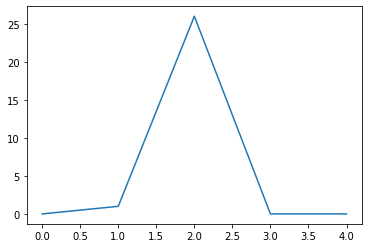

In [32]:
x_data = [0,1,2,3,4]
y_data = [0,1,26,0,0]
plt.plot(x_data, y_data)
plt.show()

---
Voltando para o nosso problema...


In [33]:
# Vamos então retirar os reviews de tamanho nulo e os
# seus respectivos labels dos reviews:

# Pegando os indices dos reviews de tamanho nulo:
non_zero_idx_train = [i for i, review in enumerate(train_set_int) if len(review) != 0]
non_zero_idx_test = [i for i, review in enumerate(test_set_int) if len(review) != 0]

In [34]:
# Removendo os reviews nulos e seus labels:
train_set_int = [train_set_int[i] for i in non_zero_idx_train]
encoded_labels = np.array([encoded_labels[i] for i in non_zero_idx_train])
test_set_int = [test_set_int[i] for i in non_zero_idx_test]

print("Número de reviews antes da remoção dos reviews nulos: 156060")
print("Número de reviews após a remoção dos reviews nulos: ", len(train_set_int))

Número de reviews antes da remoção dos reviews nulos: 156060
Número de reviews após a remoção dos reviews nulos:  156033


### Realizando o preenchimento (*padding*)

Para lidarmos com ambas as reviews (curtas e longas), a gente pode truncar ou preencher todos os nossos reviews, constringindo os reviews a um comprimento específico.

Para reviews menores que um determinado comprimento `seq_length`, a gente preenche o vetor com 0's. Para reviews maiores que esse mesmo comprimento, a gente trunca ele nas primeiras palavras.

Vamos considerar inicialmente um tamanho para a `seq_length` de 48, que foi o tamanho máximo encontrado.
>**Dica pra vida**: Caso estivéssemos lidando com reviews maiores, aqueles com até 2500 caracteres, um bom tamanho de truncagem poderia ser 200.

In [35]:
def padding_features(review_ints, seq_length):
    ''' Retorna vetores (features) dos review_ints contidos
        ou preenchidos até o limite de tamanho seq_length
    '''
    
    # Aqui produzimos um vetor com a forma desejada de linhas x colunas:
    features = np.zeros((len(review_ints),seq_length), dtype=int)
    
    # Para cada review:
    for i, row in enumerate(review_ints):
        features[i, -len(row):] = np.array(row[:seq_length])
    
    return features

In [36]:
seq_length = 52
features_train = padding_features(train_set_int, seq_length=seq_length)
features_test = padding_features(test_set_int, seq_length=seq_length)

# Para testar o código, podemos usar assert:
# assert len(features) == len(train_set_int), "As features devem ter o número de linhas igual ao numero de reviews"
# assert len(features[0]) == seq_length, "Cada linha deve ter o mesmo comprimento"

print(features_train[:3])
print()
print(features_test[:3])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     2   296     3 17898  7572     1  8288
      9    51     8    47    13     1  4654     8   175    47    13     1
  13710    58     3    82   545 12678    19   597     3    82  2668     5
     50     3     2    40]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     2   296     3 17898  7572     1  8288     9    51     8
     47    13     1  4654]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     2   296]]

[[   0    0    0    0    0   

### Dividindo o conjunto de treinamento em Treinamento, Validação e Teste

> Vamos agora dividir o conjunto de treinamento em três  grupos: um de validação, o outro para treinamento e um final para teste (Escolhi fazer isso para ser mais uma estapa de mensuração do código antes de submetê-lo ao benchmarking -- que é o conjunto de testes lá de cima que viemos trabalhando até aqui). Para isso:
* Vamos criar um conjunto das features para treino (`train_x`) e um conjunto de suas labels (`train_y`);
* Definir uma fração de *split* (`split_frac`) para ser a fração dos dados a serem **mantidos** no conjunto de treinamento. (Geralmente é de 0.8 ou 0.9);
* O Restante é dividido no meio, em conjunto de validação (`val_x` e `val_y`) e conjunto de teste (`test_x` e `test_y`).

In [37]:
# Escolhendo a fração de split:
split_frac = 0.8

# Índice do split
split_idx = int(len(features_train)*split_frac)

# Separando o conjunto de treino
train_x, remaining_x = features_train[:split_idx], features_train[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

# Índice de split do restante
test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

print("\t\t\t\tShapes das features:")
print("Conjunto de treino: \t\t{}".format(train_x.shape), 
      "\nConjunto de Validação: \t\t{}".format(val_x.shape),
      "\nConjunto de teste: \t\t{}".format(test_x.shape))

				Shapes das features:
Conjunto de treino: 		(124826, 52) 
Conjunto de Validação: 		(15603, 52) 
Conjunto de teste: 		(15604, 52)


### Criando DataLoaders e Batching

Agora estamos chegando na parte "legal" rsrs

Agora que temos os nossos dados *bonitinhos* em mãos, precisamos de um método para criar nossos conjuntos de inputs de forma a minimizar o *overfitting* por conta de uma ordem específica presente nos dados.

Uma forma é utilizando o [TensorDataset](https://pytorch.org/docs/stable/data.html#) para acessar os dados e criar os datasets. Utilizando a função *DataLoader* podemos criar pequenos *batchs*, escolhidos aleatoriamente dentre os dados.

In [38]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Criando os datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# Definindo o tamanho dos batchs
batch_size = 128

# Definindo os DataLoaders com o SHUFFLE ATIVADO (isso é importante!)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [39]:
# Pegando um batch dos dados de treinamento:

dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Tamanho do input da amostra: ', sample_x.size()) # batch_size, seq_length
print('Input amostra: \n', sample_x)
print()
print('Tamanho do label da amostra: ', sample_y.size()) # batch_size
print('Label amostra: \n', sample_y)

Tamanho do input da amostra:  torch.Size([128, 52])
Input amostra: 
 tensor([[    0,     0,     0,  ...,    16,   556,  4518],
        [    0,     0,     0,  ...,     3,     1,    56],
        [    0,     0,     0,  ...,   197,    10,   392],
        ...,
        [    0,     0,     0,  ...,     0,     0, 11827],
        [    0,     0,     0,  ...,     1,  5099,  3431],
        [    0,     0,     0,  ...,     0,     0, 10288]])

Tamanho do label da amostra:  torch.Size([128])
Label amostra: 
 tensor([0, 3, 2, 1, 1, 2, 2, 3, 2, 3, 1, 2, 3, 2, 2, 2, 1, 2, 2, 3, 1, 2, 1, 3,
        3, 3, 2, 2, 2, 2, 3, 3, 4, 2, 2, 1, 1, 0, 0, 3, 3, 1, 2, 2, 2, 1, 1, 2,
        3, 2, 2, 3, 1, 1, 1, 2, 2, 0, 2, 0, 2, 4, 2, 2, 0, 1, 3, 2, 1, 4, 1, 2,
        2, 3, 1, 2, 2, 2, 1, 2, 3, 2, 3, 1, 3, 2, 3, 4, 0, 2, 4, 3, 3, 4, 3, 1,
        2, 2, 2, 1, 2, 3, 0, 2, 1, 2, 2, 3, 2, 0, 2, 2, 4, 1, 2, 2, 2, 2, 2, 1,
        1, 2, 2, 3, 2, 2, 3, 2])


## Rede de Sentimentos usando PyTorch

Relembrando, vamos dividir a nossa rede em três principais componentes (camadas):
1. Uma [camada de *embedding*](https://pytorch.org/docs/stable/nn.html#embedding) que converte os nossos tokens de palavras (inteiros) em vetores de um tamanho específico;
2. Uma camada de [LSTM](https://pytorch.org/docs/stable/nn.html#lstm), que é definida pelo tamanho do `hidden_state` e pelo número de camadas;
3. Uma camada de output totalmente conectada que mapeia os outputs da camada LSTM aos outputs do tamanho desejado (`output_size`);
4. E por fim uma função ativadação *softmax* que transforma os outputs em probabilidades de classe.

### A camada de *embedding*

Precisamos de uma camada de embedding pois temos mais de 19000 palavras no nosso vocabuário (este inclusive pode ser um problema no geral, pois essa quantidade é relativamente baixa em comparação às +170000 palavras não-obsoletas existentes em inglês).

### As camadas da LSTM

A LSTM vai receber um tamanho de input `input_size`, a dimensão da camada oculta `hidden_dim`, o número de camadas, uma probabilidade de dropout (no caso de múltiplas camadas) e um parâmetro de `batch_first`.

Na maioria das vezes, a rede pode ter entre 2 e 3 camadas. Adicionar essas camadas permite um aprendizado de relações mais complexas pela rede.

In [40]:
# Podemos adicionar este código para verificar se a máquina possui GPU disponível para uso
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Trainando na GPU.')
else:
    print('GPU nao disponivel, treinando na CPU.')

GPU nao disponivel, treinando na CPU.


In [41]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    Modelo de uma rede recorrente usada para realizar analise de sentimentos.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        # Aqui vamos inicializar a rede e os seus parâmetros 
        
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # Camadas de embedding e da LSTM
        # Na LSTM, deve-se colocar batch_first pois os tensores
        # de input e output tem a forma: (batch, seq, feature)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # Dropout
        self.dropout = nn.Dropout(p=0.3)
        
        # Camada linear, dropout e softmax
        self.fc = nn.Linear(hidden_dim, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)
        

    def forward(self, x, hidden):
        # Essa função é para realizar o forward pass do modelo no input e nos hidden states
        
        batch_size = x.size(0)

        # Embeddings e lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # Juntando os outputs da LSTM
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # Dropout e a camada totalmente conectada
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # Função LogSoftmax
        soft_out = self.log_softmax(out)
        
        # Reshape para o batchfirst
        soft_out = soft_out.view(batch_size, -1, self.output_size)
        soft_out = soft_out[:, -1, :] # pega as labels(o output) da ultima posiçao te todas as linhas
        
        # Retorna o último output da softmax e do hidden state
        return soft_out, hidden
    
    
    def init_hidden(self, batch_size):
        # Essa função inicializa o hidden state
        
        # Cria dois novos tensores de tamanho n_layers x batch_size x hidden_dim,
        # inicializados com zeros, pra o hidden state e a cell state da LSTM
        weight = next(self.parameters()).detach()
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

### Instanciando a rede

Vamos instanciar a rede definindo os parâmetros:
* `vocab_size`: O tamanho do nosso vocabulário, ou o range dos valores do nosso input (tokens);
* `output_size`: O tamanho do nosso output desejado; É o número de scores da nossa classe (0-4);
* `embedding_dim`: Número de colunas na tabela do embedding; É o tamanho dos nossos embeddings;
* `hidden_dim`: Número de unidades na camada oculta das nossas células de LSTM. Geralmente quanto maior, melhor a performance. Os tamanhos mais comuns são 128, 256, 512, etc.;
* `n_layers`: É o número de camadas LSTM na rede. Geralmente ficam entre 1-3.

In [59]:
# Vamos então instanciar a rede com os hyperparâmetros:
vocab_size = len(vocabulary_to_int) + 1 # +1 pelo padding de 0's
output_size = 5
embedding_dim = 200
hidden_dim = 256
n_layers = 2

In [60]:
net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(19318, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (log_softmax): LogSoftmax()
)


### Treinamento

Vamos estar usando a [CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss), a chamada *Cross Entropy Loss*. Ela foi desenhada para trabalhar com problemas de classificação com C classes. 

Nesta fase também precisamos de outros *hyperparameters*:
* `lr`: a learning rate do nosso otimizador escolhido;
* `epochs`: o número de vezes que vamos iterar pelo dataset de treinamento;
* `clip`: que é o valor máximo do gradiente para evitar o problema do "explosive gradients".

In [61]:
import torch.optim as optim
# Funções de otimização e de loss
lr = 0.001

criterion = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [64]:
epochs = 4

counter = 0
print_every = 100
clip = 5 # gradient clipping

# Move o modelo para a GPU, se disponível
# if(train_on_gpu):
#     net.cuda()

net.train()
for e in range(epochs):
    # Inicializando o hidden state
    h = net.init_hidden(batch_size)
    
    losses = []

    # Loop pelo batch
    for inputs, labels in train_loader:
        if( (inputs.shape[0],inputs.shape[1]) != (batch_size,seq_length)):
            print("Pulando problema no Shape do Input: ",inputs.shape)
            continue
        counter += 1
        
        #if(train_on_gpu):
        #    inputs, labels = inputs.cuda(), labels.cuda()

        # Criando novo hidden state, para nao correr o risco de 
        # fazer o backprop por todo o historico de treinamento
        h = tuple([each.detach() for each in h])

        net.zero_grad()

        output, h = net(inputs, h)
        
        loss = criterion(output.squeeze(), labels.long())
        
        losses.append(loss.item())
        
        loss.backward()
        
        # `clip_grad_norm` ajuda a prevenir o problema do "exploding gradient" nas RNNs e LSTMs
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        
        optimizer.step()

        # Estatisticas da loss
        if counter % print_every == 0:
            
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            
            for inputs, labels in valid_loader:
                
                val_h = tuple([each.detach() for each in val_h])

                #if(train_on_gpu):
                #    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.long())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 100... Loss: 0.733285... Val Loss: 1.068734
Epoch: 1/4... Step: 200... Loss: 0.654291... Val Loss: 1.059251
Epoch: 1/4... Step: 300... Loss: 0.669949... Val Loss: 1.083451
Epoch: 1/4... Step: 400... Loss: 0.740750... Val Loss: 1.086438
Epoch: 1/4... Step: 500... Loss: 0.725762... Val Loss: 1.047285
Epoch: 1/4... Step: 600... Loss: 0.726553... Val Loss: 1.054882
Epoch: 1/4... Step: 700... Loss: 0.837476... Val Loss: 1.057664
Epoch: 1/4... Step: 800... Loss: 0.633633... Val Loss: 1.081536
Epoch: 1/4... Step: 900... Loss: 0.651102... Val Loss: 1.058119
Epoch: 2/4... Step: 1000... Loss: 0.560727... Val Loss: 1.102993
Epoch: 2/4... Step: 1100... Loss: 0.693292... Val Loss: 1.089112
Epoch: 2/4... Step: 1200... Loss: 0.666575... Val Loss: 1.116117
Epoch: 2/4... Step: 1300... Loss: 0.745819... Val Loss: 1.103957
Epoch: 2/4... Step: 1400... Loss: 0.702927... Val Loss: 1.062843
Epoch: 2/4... Step: 1500... Loss: 0.744925... Val Loss: 1.060209
Epoch: 2/4... Step: 1600... Loss: 

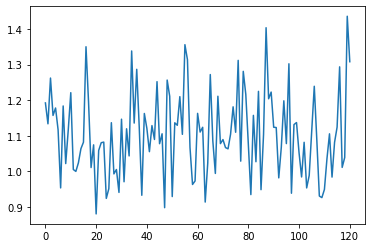

In [65]:
plt.plot(val_losses)
plt.show()

In [66]:
# Salvando o modelo:
torch.save(net.state_dict(), 'sentiment_net.pt')

# Para abrir:
net.load_state_dict(torch.load('sentiment_net.pt'))

<All keys matched successfully>

## Testando a rede

Existem algumas formas de testar uma rede neural. Podemos testá-la através de:

* **Teste de performance dos dados**: Primeiro vemos como nosso modelo performa em todos os `test_data` lá de cima, calculando o loss médio e a acurácia sobre os dados de teste;
* **Inferência em dados gerados pelo usuário**: Podemos inserir um review por vez (sem o label) e ver o que o modelo treinado retorna.

Aqui vou me ater apenas ao primeiro caso:

In [67]:
# Pegando os dados de test_loss e de acurácia:
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

h = net.init_hidden(batch_size)

net.eval()
for inputs, labels in test_loader:

    h = tuple([each.data for each in h])

#     if(train_on_gpu):
#         inputs, labels = inputs.cuda(), labels.cuda()

    output, h = net(inputs, h)

    loss = criterion(output, labels.long())
    
    test_loss += loss.item()*inputs.size(0)
    
    # Convertendo as probabilidades do output para a classe prevista:
    _, pred = torch.max(output, 1)
    
    # Comparando as previsões com o label verdadeiro:
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    
    # Calculando a acurácia para cada classe de reviews
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


### -- Status! -- ###
# Calculando o test_loss medio
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.127546

Test Accuracy of     0: 17% (127/735)
Test Accuracy of     1: 49% (1518/3094)
Test Accuracy of     2: 70% (5311/7565)
Test Accuracy of     3: 56% (1813/3197)
Test Accuracy of     4: 19% (173/897)

Test Accuracy (Overall): 57% (8942/15488)


Realizei no total 8 treinos completos, sendo este último uma continuação do penúltimo (o que acabou acarretando em um overfitting).

Os dados sobre os treinos eu deixei no arquivo texto 'treino-sentiment-rnn.txt' para consultas.

Apenas nos dois últimos treinos que realizei a verificação, sendo a melhor acurácia total obtida a de 59% (treino anterior a esse último). 

### Rápida conclusão

Nesse desafio, vimos como realizar a implementação de uma rede neural recorrente capaz de prever sentimentos de reviews.

Para uma boa implementação de um modelo como este, são necessárias três etapas importantes: A de organização e limpeza de dados, a escolha da arquitetura, e a fase de treinamento e validação. 

Por fim, é possivel aprimorarmos a rede se utilizarmos outros conjuntos de dados, por exemplo: com um conjunto de dados mais limpo (retirando as "frases" de comprimento menor que 3. É possível também buscarmos um vocabulário mais completo, e treinarmos uma camada de embedding separadamente da rede recorrente.
